*   Регулярными выражениями взять название книги из списка лит-ры
*   Брать названия онлайн курсов для дисциплины, чтобы тоже сделать эмбединг
*   Мб если на раздел выделено больше часов, то больший приоритет отдавать схожим с ним уч.сущностям?? Ерунда?
*   посмотреть -- если подходящая уч.сущность входит в другую, то ее тоже рекомендовать?.. что-то со связями придумать

In [ ]:
#@title Загрузка библиотек и данных
# for TF-Hub universal encoder
%%capture
!pip install numpy==1.19.5
!pip install PyDrive

import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import re # только в черновике

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# скачиваем данные
import glob

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/bachelor/!Диплом/d/'
all_files = glob.glob(path+'*.csv')

dfs = []
for f in all_files:
  dfs.append(pd.read_csv(f,sep=';'))

drive.flush_and_unmount()

# Присваиваем все таблицы

## -- Для всего + рек-ии результатов

In [ ]:
dp_domains,dp_items,dp_relations,\
wp_aplan,wp_additional,wp_bib_ref,wp_disc_b,wp_disc_bm,\
wp_disc_s,wp_disc_seval,wp_eval,wp_fos,wp_iaplan,\
wp_iaplan_fos,wp_outcomes,wp_outcomes_eval,\
wp_prereq,wp_topic,wp_wp,wp_wpbib_ref,\
wp_wp_disc_bm,wp_wp_isu,wp_wp_fos,wp_cert_eval = dfs

In [ ]:
# Все РПД
wp_wp.head(4)

,id,title,hoursFirstSemester,hoursSecondSemester,qualification,discipline_code,approval_date,authors,description,video,subject_code,credit_units,semester_hour,owner_id,work_status,hours,extra_points,language,structural_unit_id,have_course_project,have_diff_pass,have_exam,have_pass,lab_hours,lecture_hours,old_discipline_code,practice_hours,srs_hours,wp_isu_id
0,3689,Пищевая химия,NaN,NaN,bachelor,06.1.5.26.18,2020-08-04 17:55:37.324431+03,NaN,NaN,NaN,44,"0,0,0,0,4,0,0,0,0,0,0,0",NaN,NaN,w,NaN,NaN,ru,11.0,NaN,NaN,NaN,NaN,"0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0",06.1.5.38.18,"0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,0.0,0.0,73.6,0.0,0.0,0.0,0.0,0.0",26155.0
1,2648,Современный C++,NaN,NaN,bachelor,06.0.6.19.18,2020-08-04 17:39:33.064108+03,NaN,NaN,NaN,14,"0,0,3,0,0,0,0,0,0,0,0,0",NaN,NaN,w,NaN,NaN,ru,14.0,NaN,NaN,NaN,NaN,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0",06.0.6.10.18,"0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,55.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0",26505.0
2,2686,Дифференциальные уравнения и ТФКП,NaN,NaN,bachelor,06.5.6.62.18,2020-08-04 17:39:39.412693+03,NaN,NaN,NaN,40,"0,0,0,0,4,0,0,0,0,0,0,0",NaN,NaN,w,NaN,NaN,ru,14.0,NaN,NaN,NaN,NaN,"0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0",06.5.6.4.18,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,0.0,0.0,91.19999999999999,0.0,0.0,0.0,...",35677.0
3,3926,Основы конкурентоспособности предприятий,NaN,NaN,bachelor,06.4.6.27.18,2020-08-04 17:56:38.312651+03,NaN,NaN,NaN,48,"0,0,0,0,0,0,0,5,0,0,0,0",NaN,NaN,w,NaN,NaN,ru,1.0,NaN,NaN,NaN,NaN,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0","0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0",06.4.6.27.18,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0","0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.2,0.0,0.0",26064.0


In [ ]:
# разделы с распределением часов
wp_disc_s.head(4)

,id,name,work_program_id,SRO,contact_work,laboratory,lecture_classes,practical_lessons,total_hours,ordinal_number
0,17,Теоретические основы метрологии,5,4.0,2.2,0.0,2.0,0.0,8.0,1
1,18,"Измерения, погрешности и неопределенности",5,10.0,13.2,8.0,4.0,0.0,35.0,2
2,20,Обработка результатов измерений,5,4.0,4.4,NaN,4.0,NaN,12.0,4
3,1208,Особенности охлаждения сверхпроводниковых устр...,12522,25.2,4.4,0.0,4.0,0.0,29.6,5


In [ ]:
# темы РПД ("содержание дисциплины")
wp_topic.head(4)

,id,number,description,discipline_section_id,url_online_course_id
0,42,1,Администрирование БД,10,NaN
1,43,2,Привилегии пользователей,10,NaN
2,44,3,Виды доступа к БД,10,NaN
3,45,4,Технические методы и средства защиты БД,10,NaN


In [ ]:
# пререквизиты обучения в РПД
wp_prereq.head(4)

,id,masterylevel,item_id,workprogram_id
0,106,1,427,2811
1,107,1,428,2811
2,108,1,409,2811
3,109,2,427,6986


In [ ]:
# результаты обучения в РПД
wp_outcomes.head(4)

,id,masterylevel,item_id,workprogram_id
0,44816,2,9506,12684
1,44817,2,9502,12685
2,303,3,620,2730
3,305,3,1415,2730


In [ ]:
# учебные сущности
dp_items = dp_items[dp_items['name'].notna()]
dp_items

,id,name,value,source,author_id,domain_id
0,150,Эйлеровы графы,16,uploaded,1.0,15.0
1,151,Эйлеров цикл,16,uploaded,1.0,15.0
2,152,Эйлеров путь,16,uploaded,1.0,15.0
3,153,Эйлеровость орграфов,16,uploaded,1.0,15.0
4,155,Графы де Брюина,16,uploaded,1.0,15.0
...,...,...,...,...,...,...
18346,18559,Химический состав нутриентов,2,NaN,NaN,59.0
18347,18913,Компьютерное моделирование нелинейных финансов...,1,NaN,NaN,17.0
18348,18914,Проектирование тепломассообменного оборудования,1,NaN,NaN,88.0
18349,18916,Программируемые логические контроллеры,0,NaN,NaN,52.0


In [ ]:
len(('oejo wo fjow ojo').split())

4

In [ ]:
dp_items1 = dp_items.copy()
dp_items1['len'] = dp_items1.name.apply(lambda x: len(x.split()))
dp_items1[dp_items1.len > 2]

,id,name,value,source,author_id,domain_id,len
4,155,Графы де Брюина,16,uploaded,1.0,15.0,3
5,156,Деревья Эйлерова обхода,16,uploaded,1.0,15.0,3
11,179,Кратчайшие пути в графах,23,uploaded,1.0,15.0,4
20,207,Алгоритм вырезания соцветий,13,uploaded,1.0,15.0,3
21,119,Метод ближайших соседей,81,uploaded,1.0,15.0,3
...,...,...,...,...,...,...,...
18346,18559,Химический состав нутриентов,2,NaN,NaN,59.0,3
18347,18913,Компьютерное моделирование нелинейных финансов...,1,NaN,NaN,17.0,5
18348,18914,Проектирование тепломассообменного оборудования,1,NaN,NaN,88.0,3
18349,18916,Программируемые логические контроллеры,0,NaN,NaN,52.0,3


In [ ]:
dp_items1.len.value_counts(normalize=True)

2     0.327357
3     0.268229
4     0.169373
5     0.093134
1     0.078692
6     0.036022
7     0.017057
8     0.005886
9     0.001853
10    0.000981
11    0.000599
14    0.000436
12    0.000163
13    0.000109
20    0.000054
17    0.000054
Name: len, dtype: float64

---
## -- Для рек-ии пререквизитов:


In [ ]:
# учебные планы
# academic_plan_id -- id для сайта; id -- id для таблиц
wp_iaplan.head(3)

,id,year,academic_plan_id,period_of_study,op_isu_id,ns_id,ap_isu_id,educational_profile,language,qualification,title
0,531,2019,473,NaN,6960,3893,11687,NaN,ru,bachelor,Нейротехнологии и программирование
1,493,2018,435,NaN,6215,3108,10555,NaN,ru,bachelor,Информатика и программирование
2,528,2020,470,NaN,6959,3892,13280,NaN,ru,bachelor,Компьютерные технологии в дизайне


In [ ]:
# предметная область
wp_fos.head(4)

,id,number,qualification,education_form,educational_profile,title,faculty
0,15734,01.03.02,bachelor,NaN,NaN,Прикладная математика и информатика,NaN
1,15735,01.04.02,master,NaN,NaN,Прикладная математика и информатика,NaN
2,15736,02.04.03,master,NaN,NaN,Математическое обеспечение и администрирование...,NaN
3,15737,07.04.04,master,NaN,NaN,Градостроительство,NaN


In [ ]:
# связь уч.плана и предметной области
wp_iaplan_fos.head(5)

,id,implementationacademicplan_id,fieldofstudy_id
0,34,493,15734
1,35,494,15734
2,36,495,15734
3,37,496,15734
4,38,497,15735




---



In [ ]:
# модули в блоках в уч.плане
wp_disc_bm.head(4)

,id,name,descipline_block_id,order,description,type
0,8461,Универсальный модуль,1695,2,NaN,faculty_module
1,8462,Модуль «Философия+Мышление»,1695,5,NaN,faculty_module
2,8463,Модуль «Цифровая культура»,1695,7,NaN,faculty_module
3,8464,Модуль «Предпринимательская культура»,1695,8,NaN,faculty_module


In [ ]:
# соответствие уч.плана блокам
wp_disc_b.head(4)

,id,name,academic_plan_id
0,1695,Блок 1. Модули (дисциплины),435
1,1696,Блок 2. Практика,435
2,1697,Блок 3. ГИА,435
3,1698,Блок 4. Факультативные модули (дисциплины),435


In [ ]:
# распр-ие РПД по модулям в уч.плане
wp_wp_fos.head(3)

,id,work_program_id,work_program_change_in_discipline_block_module_id,id_str_up
0,41411,2623,32043,NaN
1,41412,2624,32044,NaN
2,41413,2625,32045,NaN


In [ ]:
# распр-ие РПД по модулям в уч.плане (2)
wp_wp_disc_bm.head(4)

,id,discipline_block_module_id,change_type,semester_hour,credit_units,code,subject_code
0,32043,8461,0,NaN,"0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,1
1,32044,8461,0,NaN,"0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,2
2,32045,8461,0,NaN,"1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,3
3,32046,8462,0,NaN,"0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0",NaN,4


# Предобработка текст.данных

In [ ]:
#@title Загрузка библиотек
%%capture
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru

from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import nltk
import gensim
import pymorphy2
nltk.download('stopwords')
nltk.download('punkt')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS


In [ ]:
def preprocess(df,clmn_name):
  '''
    Нижний регистр, удаление стоп-слов и пунктуации, лемматизация. 
    Аргументы: 
        df -- таблица; 
        clmn_name -- название колонки с текст.данными для предобработки. 
    Возвращает: копию таблицы с предобработанными текст.данными в колонке 'prepro'.
  '''

  df_new = df.copy()

  ru_stopw = stopwords.words('russian')
  morph = pymorphy2.MorphAnalyzer()
  nlp = spacy.load('en')

  # токенизация + убираем пунктуацию
  #df_new['prepro'] = df_new[clmn_name].apply(lambda x: (simple_preprocess(str(x), deacc=True)))

  # англ: токенизация, лемматизация, убираем стоп-слова/пунктуцацию
  df_new['prepro'] = df_new[clmn_name].apply(lambda x:[i.lemma_ for i in nlp(x) 
                                                                  if not i.is_stop and not i.is_punct])

  # рус: лемматизация, убираем стоп-слова, объединяем в строку
  df_new['prepro'] =  df_new['prepro'].apply(lambda x:' '.join([morph.parse(word)[0].normal_form for word in x 
                                                                  if not morph.parse(word)[0].normal_form in ru_stopw]))

  return df_new

In [ ]:
'''
#30мин где-то выполняется
wp_topic_prepro = preprocess(wp_topic,'description')
wp_disc_s_prepro = preprocess(wp_disc_s,'name')
dp_items_prepro = preprocess(dp_items,'name')'''

In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/!Диплом/d/prepro/'

with open(path+'wp_topic_prepro.csv', 'w') as f:
  wp_topic_prepro.to_csv(f, sep=';')
  f.close()

with open(path+'wp_disc_s_prepro.csv', 'w') as f:
  wp_disc_s_prepro.to_csv(f, sep=';')
  f.close()

with open(path+'dp_items_prepro.csv', 'w') as f:
  dp_items_prepro.to_csv(f, sep=';')
  f.close()

drive.flush_and_unmount()'''

In [ ]:
# сохраняем предобработанные таблицы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/!Диплом/d/prepro/'

with open(path+'wp_topic_prepro.csv') as f:
  wp_topic_prepro = pd.read_csv(f, sep=';')
  f.close()

with open(path+'wp_disc_s_prepro.csv') as f:
  wp_disc_s_prepro = pd.read_csv(f, sep=';')
  f.close()

with open(path+'dp_items_prepro.csv') as f:
  dp_items_prepro = pd.read_csv(f, sep=';')
  f.close()
  
drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
wp_disc_s_prepro.head()

,Unnamed: 0,id,name,work_program_id,SRO,contact_work,laboratory,lecture_classes,practical_lessons,total_hours,ordinal_number,prepro
0,0,17,Теоретические основы метрологии,5,4.0,2.2,0.0,2.0,0.0,8.0,1,теоретический основа метрология
1,1,18,"Измерения, погрешности и неопределенности",5,10.0,13.2,8.0,4.0,0.0,35.0,2,измерение погрешность неопределённость
2,2,20,Обработка результатов измерений,5,4.0,4.4,NaN,4.0,NaN,12.0,4,обработка результат измерение
3,3,1208,Особенности охлаждения сверхпроводниковых устр...,12522,25.2,4.4,0.0,4.0,0.0,29.6,5,особенность охлаждение сверхпроводниковый устр...
4,4,28,Системная и программная архитектура,2811,29.5,27.5,16.0,9.0,NaN,56.0,2,системный программный архитектура




---



# 1 вариант: Поиск уч.сущностей в названиях тем/разделов

убрали нан из таблицы сущностей, т.к. [item for item in items_list if item in x] -- ошибка

In [ ]:
dp_items_prepro[dp_items_prepro.prepro.isna()]

,id,name,value,source,author_id,domain_id,prepro


In [ ]:
dp_items_prepro.iloc[3038,-1]='can'
dp_items_prepro.iloc[5540,-1]='система can'

In [ ]:
#dp_items_prepro.drop('Unnamed: 0',axis=1, inplace=True)

In [ ]:
dp_items_prepro[dp_items_prepro.id==6152]

,id,name,value,source,author_id,domain_id,prepro
5540,6152,Система CAN,6,uploaded,1.0,17.0,система can


In [ ]:
def itemDiscMatches(discipline_id = 12223, to_return=10):
  '''
    Поиск уч.сущностей, встречаемых в названиях тем/разделов дисциплины.
    Аргументы:
        discipline_id -- id РПД;
        to_return -- кол-во рекомендаций;
    Возвращает: dataframe со встреченными уч.сущностями.
  '''

  # разделы дисциплины
  needed_sections = wp_disc_s_prepro[wp_disc_s_prepro['work_program_id']==discipline_id].copy()
  section_ids = needed_sections.id.values
  # названия тем дисциплины
  needed_topics = wp_topic_prepro[wp_topic_prepro['discipline_section_id'].isin(section_ids)].copy()

  # учебные сущности в виде списка
  items_list = dp_items_prepro['prepro'].unique().tolist()

  # выписываем упоминаемые в темах/разделах уч.сущности в отд.колонки
  needed_topics['items'] = needed_topics['prepro'].apply(
      lambda x: [item for item in items_list if item in x])
  needed_sections['items'] = needed_sections['prepro'].apply(
      lambda x: [item for item in items_list if item in x])
  # удаляем темы/разделы, где не упоминались уч.сущности
  needed_topics = needed_topics[needed_topics['items'].astype(bool)]
  needed_sections = needed_sections[needed_sections['items'].astype(bool)]

  # только уникальные встреченные уч.сущности
  topics_sections = needed_sections['items'].append(needed_topics['items'])

  # считаем частоту
  item_names, count = np.unique(np.array([item for sublist in topics_sections 
                                          for item in sublist]), return_counts=True)

  # добавляем значения частоты уч.сущностей в таблицу
  fin_df = dp_items_prepro[dp_items_prepro['prepro'].isin(item_names)].copy()
  len = fin_df.shape[0]
  fin_df['val'] = 0
  fin_df['perc'] = 0
  for item,value in zip(item_names,count):
    fin_df.loc[fin_df['prepro']==item,'val'] = value
    fin_df.loc[fin_df['prepro']==item,'perc'] = value/len
  # т.к. есть уч.сущности с пробелами на конце
  fin_df = fin_df[-fin_df['name'].str.strip().duplicated()]
  return fin_df.sort_values('val',ascending=False).nlargest(to_return,'val')


In [ ]:
matched = itemDiscMatches(12223,15)
matched

,id,name,value,source,author_id,domain_id,prepro,val,perc
13167,13932,Дизайн,0,NaN,NaN,NaN,дизайн,6,0.428571
17158,17923,Игра,0,NaN,NaN,NaN,игра,6,0.428571
490,633,История,70,uploaded,1.0,16.0,история,4,0.285714
2932,3249,Конфликт,14,uploaded,1.0,29.0,конфликт,2,0.142857
6679,7146,Механика,13,uploaded,1.0,20.0,механика,2,0.142857
559,729,Данные,98,uploaded,1.0,17.0,дать,1,0.071429
2498,2801,Структуры Ли,15,uploaded,1.0,11.0,структура,1,0.071429
3326,3650,Интерактивные элементы,12,uploaded,1.0,17.0,интерактивный элемент,1,0.071429
6460,6930,Структура ПО,7,uploaded,1.0,17.0,структура,1,0.071429
10398,11140,Ресурсы,11,uploaded,1.0,25.0,ресурс,1,0.071429


In [ ]:
matched = itemDiscMatches(6986,15)
matched

,id,name,value,source,author_id,domain_id,prepro,val,perc
549,717,CSS,57,uploaded,1.0,28.0,css,6,0.400000
548,716,HTML,46,uploaded,1.0,28.0,html,5,0.333333
17537,18305,UX,0,NaN,NaN,NaN,ux,3,0.200000
12467,13227,Проект,0,NaN,NaN,NaN,проект,2,0.133333
13167,13932,Дизайн,0,NaN,NaN,NaN,дизайн,2,0.133333
16306,17064,Проектирование ПО,0,NaN,NaN,NaN,проектирование,2,0.133333
17359,18126,Проектирование,0,NaN,NaN,NaN,проектирование,2,0.133333
17538,18306,UI,0,NaN,NaN,NaN,ui,2,0.133333
279,461,Классы,26,uploaded,1.0,17.0,класс,1,0.066667
1559,1813,Bootstrap,23,uploaded,1.0,14.0,bootstrap,1,0.066667


In [ ]:
%%timeit
itemDiscMatches()

10 loops, best of 5: 77.8 ms per loop


# 2 вариант: Сходство уч.сущностей и тем

Векторные представления уч.сущностей + тем.
- можно попробовать взять не предобученные модели, а обучить на учебниках\текстах онлайн-курсов?
- (X: не нашла multilingual word emb-s, которые нормально работают) попробовать word2vec,GloVe,fasttext -- либо среднее векторов слов для предложения, либо doc2vec, либо...
- можно выводить самые частые домены?чтобы преподаватель знал, где искать вручную уч.сущности. Или это и так им очевидно должно быть

## -- Ф-ии

In [ ]:
def plot_similarity(topics, items, all_vectors):
  '''
    Матрица корелляции + ее визуализация. 
    Аргументы: 
        topics -- список названий тем; 
        items -- список названий уч.сущностей;
        all_vectors -- список с векторами и тем, и уч.сущностей. 
    Возвращает: матрицу корелляции и график.
  '''
  len = topics.shape[0]

  #оставляем только часть сверху справа.
  corr = np.inner(all_vectors[:len], all_vectors[len:])
  sns.set(font_scale=0.6)
  #PuBuGn
  g = sns.heatmap(corr,vmin=0,vmax=1,cmap="YlGnBu")

  return corr,g

In [ ]:
def corrItems(labels,topics,items,all_vectors,threshold=0.8):
  '''
    Поиск уч.сущностей, которые похожи на названия тем 
    (выбирает только одну сущность с макс.значением для каждой темы).
    Аргументы: 
        labels -- список названий, которые будут выведены в итоге;
        topics -- список названий тем; 
        items -- список названий уч.сущностей;
        all_vectors -- список с векторами и тем, и уч.сущностей;
        threshold -- порог значений. 
    Возвращает: таблицу с темами и соответствующими уч.сущностями 
                + визуализацию матрицы корелляции.
  '''
  corr_m, plot = plot_similarity(topics,items,all_vectors)
  corr_m_new = corr_m.copy()

  new_df = pd.DataFrame(labels[0],columns=['name'])
  new_df['value']=corr_m_new.max(axis=1)
  new_df['item'] = corr_m_new.argmax(axis=1)
  new_df['item_name'] = new_df['item'].apply(lambda x: labels[1][x])

  return new_df[new_df.value>threshold], plot

In [ ]:
def corrItemsList(topics,items,all_vectors,threshold=0.8):
  '''
    Поиск уч.сущностей, которые похожи на названия тем. 
    Выбирает все сущности, значение которых выше порога.
    Аргументы: 
        topics -- список названий тем; 
        items -- список названий уч.сущностей;
        all_vectors -- список с векторами и тем, и уч.сущностей;
        threshold -- порог значений. 
    Возвращает: таблицу с уч.сущностями + визуализацию матрицы корелляции.
  '''
  corr_m, plot = plot_similarity(topics,items,all_vectors)
  corr_m_new = corr_m.copy()

  corr_items = np.where(np.any(corr_m_new > threshold, axis=0))

  return np.unique(corr_items), plot

In [ ]:
def itemDiscSim(discipline_id, vec_func, items_vec=False, threshold=0.65, to_return=10):
  '''
    Поиск уч.сущностей, которые похожи на названия тем/разделов дисциплины. 
    Выбирает все сущности, значения которых выше порога.
    Аргументы: 
        discipline_id -- id дисциплины;
        vec_func -- функция векторизации;
        items_vec -- готовые векторы для уч.сущностей;
        threshold -- порог значений;
        to_return -- кол-во рекомендаций. 
    Возвращает: таблицу с уч.сущностями
  '''
  # разделы дисциплины
  needed_sections = wp_disc_s[wp_disc_s['work_program_id']==discipline_id].copy()
  section_ids = needed_sections.id.values
  # названия тем дисциплины
  needed_topics = wp_topic[wp_topic['discipline_section_id'].isin(section_ids)].copy()
  # будем искать соответствия И в темах, И в разделах
  all_headers = np.append(needed_sections['name'].values, needed_topics['description'].values)

  # если были поданы на вход векторы уч.сущностей
  if items_vec is not False:
    headers_vecs = vec_func(all_headers)
  else:
    headers_vecs, items_vec = vec_func(all_headers,dp_items['name'].values)

  # строим матрицу сходства
  len = all_headers.shape[0]
  sim_m = np.inner(headers_vecs, items_vec)

  # ищем id и значения подходящих элементов
  ids = np.where(np.any(sim_m > threshold, axis=0))
  vals = np.max(sim_m[:,ids],axis=0)[0]
  
  # добавляем данные в новую таблицу
  df = dp_items.iloc[ids].copy()
  df['similarity'] = vals

  return df.sort_values('similarity',ascending=False).nlargest(to_return, 'similarity')


## -- Elmo

Рез-ты плохие + тк длина векторов зависит от длины самого большого предложения, то нельзя заранее представить все уч.сущности в виде векторов?

In [ ]:
%%capture
!pip install --upgrade simple_elmo

In [ ]:
from google.colab import drive
from simple_elmo import ElmoModel
drive.mount('/content/drive')

model1 = ElmoModel()
model1.load('/content/drive/My Drive/!Диплом/212.zip')

drive.flush_and_unmount()

In [ ]:
model_elmo = model1

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def vecFuncELMO(headers, items):
  return model_elmo.get_elmo_vector_average(np.append(headers, items))

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
              'Sentences are passed as a list of string.', 
              'The quick brown fox jumps over the lazy dog.', 
              'Быстрая коричневая лиса перепрыгнула через ленивую собаку.',
              'Предложения передаются в виде списка строк.', 
              'Random forest','Случайный лес']

In [ ]:
temp = pd.DataFrame(sentences)

temp[0]

0    This framework generates embeddings for each i...
1            Sentences are passed as a list of string.
2         The quick brown fox jumps over the lazy dog.
3    Быстрая коричневая лиса перепрыгнула через лен...
4          Предложения передаются в виде списка строк.
5                                        Random forest
6                                        Случайный лес
Name: 0, dtype: object

In [ ]:
ru_stopw = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
nlp = spacy.load('en')
  # англ: токенизация, лемматизация, убираем стоп-слова/пунктуцацию
temp['prepro'] = temp[0].apply(lambda x:[i.lemma_ for i in nlp(x) 
                                                                  if not i.is_stop and not i.is_punct])
  # рус: лемматизация, убираем стоп-слова, объединяем в строку
temp['prepro'] =  temp['prepro'].apply(lambda x:' '.join([morph.parse(word)[0].normal_form for word in x 
                                                                  if not morph.parse(word)[0].normal_form in ru_stopw]))

2021-05-26 21:00:13,775 : INFO : Loading dictionaries from /usr/local/lib/python3.7/dist-packages/pymorphy2_dicts_ru/data
2021-05-26 21:00:13,832 : INFO : format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [ ]:
temp

,0,prepro
0,This framework generates embeddings for each i...,framework generate embedding input sentence
1,Sentences are passed as a list of string.,sentence pass list string
2,The quick brown fox jumps over the lazy dog.,quick brown fox jump lazy dog
3,Быстрая коричневая лиса перепрыгнула через лен...,быстрый коричневый лиса перепрыгнуть ленивый с...
4,Предложения передаются в виде списка строк.,предложение передаваться вид список строка
5,Random forest,random forest
6,Случайный лес,случайный лес


In [ ]:
sentence_embeddings = model1.get_elmo_vector_average(temp['prepro'].to_list())

2021-05-26 21:06:53,796 : INFO : Warming up ELMo on 7 sentences...
2021-05-26 21:06:59,084 : INFO : Warming up finished.
2021-05-26 21:06:59,089 : INFO : Texts in the current batch: 7


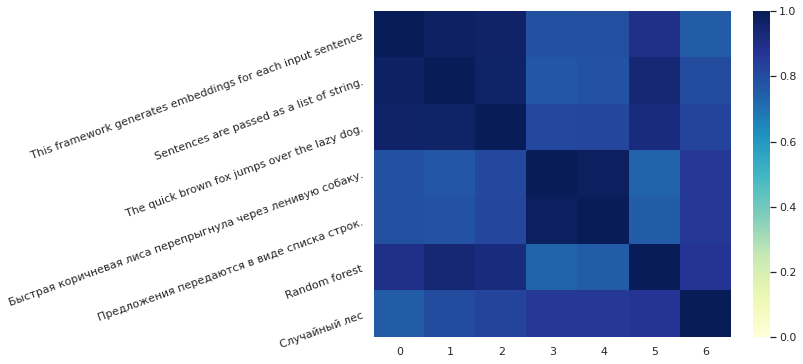

In [ ]:
import matplotlib.pyplot as plt
sns.set(font_scale=1)
plt.figure(figsize=(8, 6))
plot=sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu",yticklabels=sentences)
loc, labels = plt.yticks()
plot.set_yticklabels(labels, rotation=20);

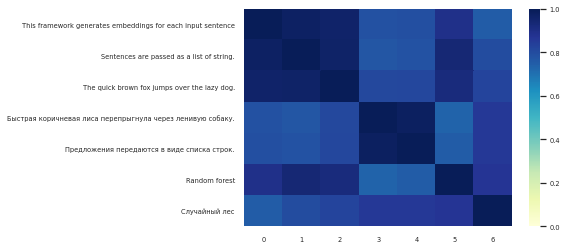

In [ ]:
sns.set(font_scale=0.6)
sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu",yticklabels=sentences)
#sns.set_xticklabels(labels, rotation=rotation)
sns.

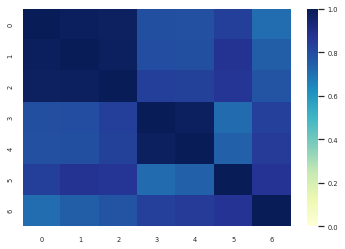

In [ ]:
sns.set(font_scale=0.6)
sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu")

## -- (V) Universal Encoder (TH-Hub)

In [ ]:
!pip install tensorflow_text>=2.0.0rc0
!pip install numpy==1.19.5

In [ ]:
import tensorflow_hub as hub

### пробуем загрузить сохраненную на диске модель

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

loaded = hub.load('/content/drive/My Drive/bachelor/!Диплом/usencoder/')

drive.flush_and_unmount()

In [ ]:
embed('i love you') ==loaded('i love you')

используем загрузку с хаба

In [ ]:
import tensorflow_hub as hub
import numpy as np
import tensorflow_text
import seaborn as sns

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

In [ ]:
%%timeit
# заранее делаем эмбединг для уч.сущностей
items_vecs = embed(dp_items['name'].values)

1 loop, best of 5: 18.4 s per loop


In [ ]:
items_vecs.numpy().shape

In [ ]:
np_vecs = items_vecs.numpy()
dp_items.id.values.shape

In [ ]:
df = pd.DataFrame({'id':dp_items.id.values,
              'emb':list(np_vecs)})
df

In [ ]:
pd.read_json(df.to_json())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


with open('/content/drive/My Drive/!Диплом/embs.json', 'w') as f:
  f.write(df.to_json())
  f.close()

drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


with open('/content/drive/My Drive/bachelor/!Диплом/embs.json') as json_file:
    read_json = pd.read_json(json_file)
    json_file.close()

drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
read_json

In [ ]:
%%timeit
np.inner(np.vstack(read_json['emb']),np.vstack(read_json['emb']))

In [ ]:
%%timeit
cosine_similarity(np.vstack(read_json['emb']))

In [ ]:
np.inner(np.vstack(read_json['emb'][:3]),np.vstack(read_json['emb'][-2:]))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
%%timeit
items_vecs = embed(dp_items['name'].values)

In [ ]:
corr = np.inner(np.vstack(read_json['emb'][:3]),np.vstack(read_json['emb'][3:100]))
new_df = pd.DataFrame(read_json['id'][:3],columns=['name'])

corr_items = np.where(np.any(corr > 0.5, axis=0))
vals = np.max(corr[:,corr_items],axis=0)[0]
df = dp_items.iloc[corr_items].copy()
df['similarity'] = vals

df.sort_values('similarity',ascending=False).nlargest(10, 'similarity')

Выше заранее вычисленные эмбеддинги записывали в файл и читали.
Ниже -- проверяем работу моделей

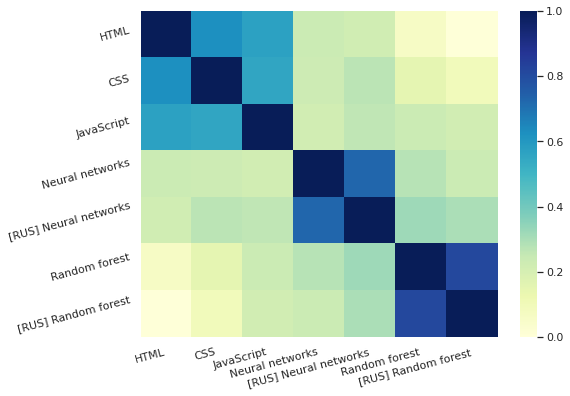

In [ ]:
sentences = ['HTML','CSS','JavaScript','Neural networks','Нейронные сети','Random forest','Случайный лес']

sentence_embeddings = embed(sentences)

sentences_lab = ['HTML','CSS','JavaScript','Neural networks','[RUS] Neural networks','Random forest','[RUS] Random forest']
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plot=sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu",yticklabels=sentences_lab, xticklabels=sentences_lab)
loc, labels = plt.yticks()
plot.set_yticklabels(labels, rotation=15);
loc, labels = plt.xticks()
plot.set_xticklabels(labels, rotation=15, ha='right');

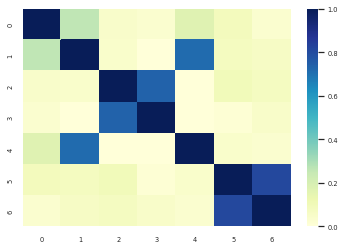

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.', 
    'Быстрая коричневая лиса перепрыгнула через ленивую собаку.',
    'Предложения передаются в виде списка строк.', 'Random forest','Случайный лес']

sentence_embeddings = embed(sentences)

sns.set(font_scale=0.6)
sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu")

### Проверяем для всех тем

In [ ]:
def plot_similarity(topics, items, all_vectors):
  '''
    Матрица корелляции + ее визуализация. 
    Аргументы: 
        topics -- список названий тем; 
        items -- список названий уч.сущностей;
        all_vectors -- список с векторами и тем, и уч.сущностей. 
    Возвращает: матрицу корелляции и график.
  '''
  len = topics.shape[0]

  #оставляем только часть сверху справа.
  corr = np.inner(all_vectors[:len], all_vectors[len:])
  sns.set(font_scale=0.6)
  #PuBuGn
  g = sns.heatmap(corr,vmin=0,vmax=1,cmap="YlGnBu")

  return corr,g

In [ ]:
topics, items_val = wp_topic['description'].values[:50], dp_items['name'].values[:1000]
all_labels = np.append(topics,items_val)
all_vectors = embed(all_labels)
corr, plot = plot_similarity(topics, items_val, all_vectors)

NameError: ignored

In [ ]:
def corrItems(labels,topics,items,all_vectors,threshold=0.8):
  '''
    Поиск уч.сущностей, которые похожи на названия тем 
    (выбирает только одну сущность с макс.значением для каждой темы).
    Аргументы: 
        labels -- список названий, которые будут выведены в итоге;
        topics -- список названий тем; 
        items -- список названий уч.сущностей;
        all_vectors -- список с векторами и тем, и уч.сущностей;
        threshold -- порог значений. 
    Возвращает: таблицу с темами и соответствующими уч.сущностями 
                + визуализацию матрицы корелляции.
  '''
  corr_m, plot = plot_similarity(topics,items,all_vectors)
  corr_m_new = corr_m.copy()

  new_df = pd.DataFrame(labels[0],columns=['name'])
  new_df['value']=corr_m_new.max(axis=1)
  new_df['item'] = corr_m_new.argmax(axis=1)
  new_df['item_name'] = new_df['item'].apply(lambda x: labels[1][x])

  return new_df[new_df.value>threshold], plot

In [ ]:
labels = [wp_topic['description'].values[:50], dp_items['name'].values[:1000]]
all_labels = np.append(labels[0],labels[1])
all_vectors = embed(all_labels)
res, plot = corrItems(labels, wp_topic['description'].values[:50], dp_items['name'].values[:1000], all_vectors,threshold=0.7)

In [ ]:
res

---
Возвращаемся -> 

In [ ]:
def corrItemsList(item_labels,topics,items,all_vectors,threshold=0.8):
  '''
    Поиск уч.сущностей, которые похожи на названия тем. 
    Выбирает все сущности, значение которых выше порога.
    Аргументы: 
        item_labels -- список названий уч.сущностей, которые будут выведены в итоге
                        (при выводе id, а не названий, не используется);
        topics -- список названий тем; 
        items -- список названий уч.сущностей;
        all_vectors -- список с векторами и тем, и уч.сущностей;
        threshold -- порог значений. 
    Возвращает: таблицу с уч.сущностями + визуализацию матрицы корелляции.
  '''
  corr_m, plot = plot_similarity(topics,items,all_vectors)
  corr_m_new = corr_m.copy()

  #corr_items = item_labels[np.where(np.any(corr_m_new > threshold, axis=0))]
  corr_items = np.where(np.any(corr_m_new > threshold, axis=0))

  return np.unique(corr_items), plot

In [ ]:
all_vectors = embed(np.append(wp_topic['description'].values,dp_items['name'].values))
resList,plot_l = corrItemsList(dp_items['name'].values, wp_topic['description'].values, dp_items['name'].values, all_vectors, threshold=0.8)

In [ ]:
dp_items.iloc[resList]

In [ ]:
# есть повторения в названиях сущностей, но вдруг повторы относились бы к разным областям?
dp_items.iloc[resList].drop_duplicates(['name','domain_id'])['name'].values

### То же, но с вводом id дисциплины

In [ ]:
def vecFuncUSE(headers):
  return embed(headers)

In [ ]:
res = itemDiscSim(12223,vecFuncUSE,items_vecs)
res

## -- BERT

Долго вычисляет + странные рез-ты?

In [ ]:
%%capture
!pip install transformers

In [ ]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from transformers import AutoModel, AutoTokenizer, BertTokenizer

torch.set_grad_enabled(False)

In [ ]:
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

2021-05-26 21:03:00,551 : INFO : Lock 140377619456464 acquired on /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052.lock


2021-05-26 21:03:21,348 : INFO : Lock 140377619456464 released on /root/.cache/huggingface/transformers/0a3fd51713dcbb4def175c7f85bddc995d5976ce1dde327f99104e4d33069f17.aa7be4c79d76f4066d9b354496ea477c9ee39c5d889156dd1efb680643c2b052.lock


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2021-05-26 21:03:24,888 : INFO : Lock 140377619483856 acquired on /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a11

2021-05-26 21:03:25,114 : INFO : Lock 140377619483856 released on /root/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock
2021-05-26 21:03:25,192 : INFO : Lock 140377619483856 acquired on /root/.cache/huggingface/transformers/46880f3b0081fda494a4e15b05787692aa4c1e21e0ff2428ba8b14d4eda0784d.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24.lock


2021-05-26 21:03:25,437 : INFO : Lock 140377619483856 released on /root/.cache/huggingface/transformers/46880f3b0081fda494a4e15b05787692aa4c1e21e0ff2428ba8b14d4eda0784d.b33e51591f94f17c238ee9b1fac75b96ff2678cbaed6e108feadb3449d18dc24.lock


2021-05-26 21:03:25,657 : INFO : Lock 140377618734416 acquired on /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


2021-05-26 21:03:25,788 : INFO : Lock 140377618734416 released on /root/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock


In [ ]:
from sklearn import preprocessing

['framework generate embedding input sentence',
 'sentence pass list string',
 'quick brown fox jump lazy dog',
 'быстрый коричневый лиса перепрыгнуть ленивый собака',
 'предложение передаваться вид список строка',
 'random forest',
 'случайный лес']

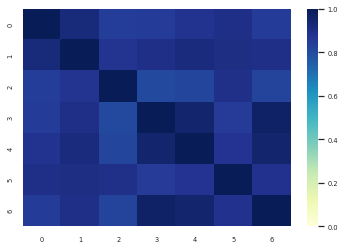

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.', 
    'Быстрая коричневая лиса перепрыгнула через ленивую собаку.',
    'Предложения передаются в виде списка строк.', 'Random forest','Случайный лес']

#tokens_pt = tokenizer(sentences, return_tensors="pt", padding=True)
tokens_pt = tokenizer(temp['prepro'].to_list(), return_tensors="pt", padding=True)

outputs = model(**tokens_pt)
pooler_output = outputs.pooler_output

sns.set(font_scale=0.6)
sns.heatmap(np.inner(preprocessing.normalize(pooler_output),preprocessing.normalize(pooler_output)),vmin=0,vmax=1,cmap="YlGnBu")

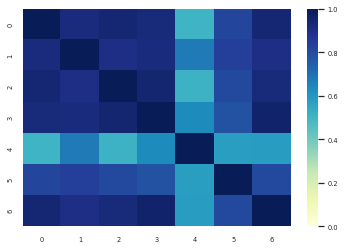

In [ ]:
np.inner(pooler_output,pooler_output)

array([[126.636925,  80.4872  , 113.7118  ,  89.03408 ,  29.241615,
         68.68401 , 102.90591 ],
       [ 80.4872  ,  60.198616,  75.23463 ,  60.9293  ,  27.185085,
         48.540928,  68.02994 ],
       [113.7118  ,  75.23463 , 114.5472  ,  86.57979 ,  28.321049,
         64.43546 ,  96.296906],
       [ 89.03408 ,  60.9293  ,  86.57979 ,  72.562515,  27.899416,
         49.463776,  79.38815 ],
       [ 29.241615,  27.185085,  28.321049,  27.899416,  26.448711,
         22.184502,  29.187   ],
       [ 68.68401 ,  48.540928,  64.43546 ,  49.463776,  22.184502,
         55.18467 ,  58.466663],
       [102.90591 ,  68.02994 ,  96.296906,  79.38815 ,  29.187   ,
         58.466663,  94.17383 ]], dtype=float32)

## -- SBERT? (2 модели)

Странные рез-ты



*   pickle -- чтобы вычислить и загрузить потом
*   Paraphrase Mining -- считает быстрее, нежели просто для каждой пары находить кос.сходство



In [ ]:
%%capture
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [ ]:
model_sbert = model

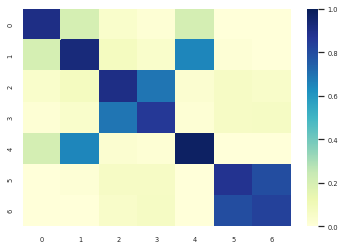

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.', 
    'Быстрая коричневая лиса перепрыгнула через ленивую собаку.',
    'Предложения передаются в виде списка строк.', 'Random forest','Случайный лес']

sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
sns.set(font_scale=0.6)
sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu")

In [ ]:
def vecFuncSBert(headers):
  return model_sbert.encode(headers, convert_to_tensor=True)


In [ ]:
item_vecs_sb = model_sbert.encode(dp_items['name'].values, convert_to_tensor=True)

In [ ]:
res = itemDiscSim(12223,vecFuncSBert,item_vecs_sb)
res
# игра 0.9, хотя есть 100%соответствие в теме

,id,name,value,source,author_id,domain_id,similarity
17159,17923,Игра,0,NaN,NaN,NaN,0.901437
627,867,Методы построения,64,uploaded,1.0,14.0,0.704804
7509,8058,Методы разработки архитектуры,7,uploaded,1.0,17.0,0.694217
6131,6558,Методы конструирования технологической оснастки,10,uploaded,1.0,36.0,0.684116
18306,18885,Прототипирование игровых механик,1,NaN,NaN,17.0,0.653086




---
Проверим на 2-й модели. В док-ии написано, что хоть языков больше, но точность на 15-ти изначальных (из 1-й модели) ниже


In [ ]:
model_v2 = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [ ]:
def vecFuncSBert2(headers):
  return model_v2.encode(headers, convert_to_tensor=True)

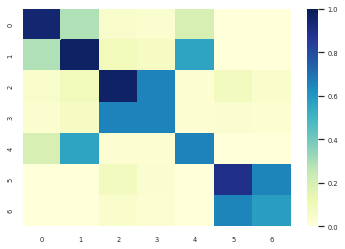

In [ ]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.', 
    'Быстрая коричневая лиса перепрыгнула через ленивую собаку.',
    'Предложения передаются в виде списка строк.', 'Random forest','Случайный лес']

sentence_embeddings = model_v2.encode(sentences, convert_to_tensor=True)
sns.set(font_scale=0.6)
sns.heatmap(np.inner(sentence_embeddings,sentence_embeddings),vmin=0,vmax=1,cmap="YlGnBu")

In [ ]:
item_vecs_sb = model_v2.encode(dp_items['name'].values, convert_to_tensor=True)

In [ ]:
res = itemDiscSim(12223,vecFuncSBert2,item_vecs_sb,threshold=0.4)
res

,id,name,value,source,author_id,domain_id,similarity
7509,8058,Методы разработки архитектуры,7,uploaded,1.0,17.0,0.536467
1996,2267,Методики описания системной архитектуры,11,uploaded,1.0,17.0,0.502733
9361,9956,Методики описания архитектуры предприятия,10,uploaded,1.0,18.0,0.491816
1303,1554,Требования к структуре хорошей истории,9,uploaded,1.0,30.0,0.487548
627,867,Методы построения,64,uploaded,1.0,14.0,0.463450
17817,18492,Структурный подход к нарративу,1,NaN,NaN,62.0,0.459777
17159,17923,Игра,0,NaN,NaN,NaN,0.453946
490,633,История,70,uploaded,1.0,16.0,0.451369
18306,18885,Прототипирование игровых механик,1,NaN,NaN,17.0,0.443785
1312,1560,Теория игр,29,uploaded,1.0,11.0,0.442421


---
# Пререквизиты

Взяли рез-ты всех РПД из всех Уч.Планов, находящихся в списке ранее текущего. И что дальше?

Можно у текущей РПД найти рез-ты + узнать их самые частые предм.области. Затем из чужих рез-в выбрать из самой частой предм.области.

Или в зависимости от модуля (например, универсальный или элективы) как-то по-разному?

In [ ]:
#учебные планы
wp_iaplan.head()

,id,year,academic_plan_id,period_of_study,op_isu_id,ns_id,ap_isu_id,educational_profile,language,qualification,title
0,531,2019,473,NaN,6960,3893,11687,NaN,ru,bachelor,Нейротехнологии и программирование
1,493,2018,435,NaN,6215,3108,10555,NaN,ru,bachelor,Информатика и программирование
2,528,2020,470,NaN,6959,3892,13280,NaN,ru,bachelor,Компьютерные технологии в дизайне
3,526,2018,468,NaN,6959,3892,10559,NaN,ru,bachelor,Компьютерные технологии в дизайне
4,523,2019,465,NaN,7140,4071,11678,NaN,ru,bachelor,Мобильные и сетевые технологии


объедияем таблицы

In [ ]:
# распределение РПД по модулям в уч.плане
wp_in_bmodules = wp_wp_disc_bm.merge(wp_wp_fos, left_on='id', right_on='work_program_change_in_discipline_block_module_id').iloc[:,:-2]
wp_in_bmodules.head(4)

,id_x,discipline_block_module_id,change_type,semester_hour,credit_units,code,subject_code,id_y,work_program_id
0,32043,8461,0,NaN,"0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,1,41411,2623
1,32044,8461,0,NaN,"0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,2,41412,2624
2,32045,8461,0,NaN,"1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,3,41413,2625
3,32046,8462,0,NaN,"0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0",NaN,4,41414,2626


In [ ]:
# распределение РПД по модулям и блокам в уч.плане
wp_in_ap = wp_in_bmodules.merge(wp_disc_bm.iloc[:,:-2], left_on='discipline_block_module_id',right_on='id')
wp_in_ap.head(3)

,id_x,discipline_block_module_id,change_type,semester_hour,credit_units,code,subject_code,id_y,work_program_id,id,name,descipline_block_id,order
0,32043,8461,0,NaN,"0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,1,41411,2623,8461,Универсальный модуль,1695,2
1,32044,8461,0,NaN,"0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,2,41412,2624,8461,Универсальный модуль,1695,2
2,32045,8461,0,NaN,"1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0",NaN,3,41413,2625,8461,Универсальный модуль,1695,2


In [ ]:
outcomes_dom = wp_outcomes.merge(dp_items,left_on='item_id',right_on='id')

In [ ]:
# какие РПД в учебном плане
def wpInAplan(aplan_id = 435):
  
  # нужные блоки
  blocks = wp_disc_b[wp_disc_b['academic_plan_id']  == aplan_id].id
  # нужные модули в блоках + РПД
  bmodules_and_wp = wp_in_ap[wp_in_ap['descipline_block_id'].isin(blocks)]

  bmodules_and_wp = bmodules_and_wp.loc[:,['id_x','discipline_block_module_id',
                                           'subject_code','work_program_id','id',
                                           'name','descipline_block_id','order']]
  #сортируем по порядку модулей и по порядку РПД
  return bmodules_and_wp.sort_values(by=['order','subject_code'])  


# список РПД, которые стоят в уч. плане раньше текущей
def ealierWpInAplan(wp_id = 2627, aplan_id=435):
  needed_aplan = wpInAplan(aplan_id)
  # ищем место РПД в списке
  wp_index = needed_aplan[needed_aplan.work_program_id==wp_id].index[0]

  return needed_aplan.iloc[:wp_index,:].work_program_id  

In [ ]:
def earlierWpRes(wp_id = 2623, to_return=10):
  '''
    Поиск учебных сущностей, которые часто встречаются в РПД,
    стоящих ранее в связанных учебных планах.
    Аргументы:
        wp_id -- id дисциплины;
        to_return -- кол-во рекомендаций.
    Возвращает: таблицу с уч.сущностями
  '''
  # в каких уч.планах есть РПД:
    # в каких блоках встречается РПД
  blocks = wp_in_ap[wp_in_ap.work_program_id==wp_id].descipline_block_id.unique()
    # в каких уч.планах находятся блоки
  ap_ids = wp_disc_b[wp_disc_b.id.isin(blocks)].academic_plan_id.unique()

  # составляем список РПД, которые находятся раньше, из всех уч.планов
  earlier_wps = np.array([])
  for ap in ap_ids:
    earlier_wps = np.append(earlier_wps, ealierWpInAplan(wp_id, ap).values)
  
  # составляем список всех результатов для всех РДП 
  earlier_res, res_count = np.unique(wp_outcomes[wp_outcomes.workprogram_id.isin(
                                      earlier_wps)].item_id.values, return_counts=True)
  
  # самые частые результаты
  freq_res = pd.DataFrame([earlier_res,res_count]).T[0].values
  res = dp_items[dp_items.id.isin(freq_res)].copy()

  # записываем абсолютные и относительные величины частоты
  len = res.shape[0]
  res['val'] = 0
  res['perc'] = 0
  for item,value in zip(earlier_res,res_count):
    res.loc[res['id']==item,'val'] = value
    res.loc[res['id']==item,'perc'] = value/len
  
  return res.nlargest(to_return,'perc')

In [ ]:
earlierWpRes(12186,to_return=15)

,id,name,value,source,author_id,domain_id,val,perc
6733,7203,Правовая охрана интеллектуальной собственности,18,uploaded,1.0,30.0,7,0.017241
17738,856,Нейронные сети,232,uploaded,1.0,17.0,6,0.014778
6763,7201,Научное исследование,6,uploaded,1.0,30.0,5,0.012315
1232,13255,Бизнес-модель,0,NaN,NaN,NaN,4,0.009852
2179,2405,Организация научных исследований,16,uploaded,1.0,30.0,4,0.009852
6720,7199,Международные наукометрические базы данных,6,uploaded,1.0,30.0,4,0.009852
6721,7200,Международные научные парнерства,6,uploaded,1.0,30.0,4,0.009852
6725,7202,Методологические основы научного знания,6,uploaded,1.0,30.0,4,0.009852
6727,7204,Управление в сфере науки в России,6,uploaded,1.0,30.0,4,0.009852
15433,7308,Проектная деятельность,22,uploaded,1.0,30.0,4,0.009852


In [ ]:
def earlierWpResDomain(wp_id = 2623, to_return=10):
  '''
    Поиск учебных сущностей, которые часто встречаются в РПД,
    стоящих ранее в связанных учебных планах И в той же пр.области,
    что и результаты заданной РПД.
    Аргументы:
        wp_id -- id дисциплины;
        to_return -- кол-во рекомендаций.
    Возвращает: таблицу с уч.сущностями
  '''
  # в каких уч.планах есть РПД:
    # в каких блоках встречается РПД
  blocks = wp_in_ap[wp_in_ap['work_program_id']==wp_id]['descipline_block_id'].unique()
    # в каких уч.планах находятся блоки
  ap_ids = wp_disc_b[wp_disc_b['id'].isin(blocks)]['academic_plan_id'].unique()

  # составляем список РПД, которые находятся раньше, из всех уч.планов
  earlier_wps = np.array([])
  for ap in ap_ids:
    earlier_wps = np.append(earlier_wps, ealierWpInAplan(wp_id, ap).values)

  # результаты самой РПД
  orig_res = wp_outcomes[wp_outcomes['workprogram_id'] == wp_id]['item_id'].values
  # предм.области результатов
  orig_domain = dp_items[dp_items['id'].isin(orig_res)]['domain_id'].unique()

  # составляем список всех результатов для всех РДП 
  earlier_res, res_count = np.unique(wp_outcomes[wp_outcomes['workprogram_id'].isin(
                                      earlier_wps)]['item_id'].values, return_counts=True)
  
  # возвращаем только рез-ты, которые из тех же предм.областей, что и оригинальная РПД
  item_ids = outcomes_dom[(outcomes_dom['workprogram_id'].isin(earlier_wps) & 
                (outcomes_dom['domain_id'].isin(orig_domain)))
              ].value_counts('item_id').index#[:to_return]
  len = item_ids.shape[0]
  res = dp_items[dp_items.id.isin(item_ids)].copy()

  # записываем абсолютные и относительные величины частоты
  len = res.shape[0]
  res['val'] = 0
  res['perc'] = 0
  for item,value in zip(earlier_res,res_count):
    res.loc[res['id']==item,'val'] = value
    res.loc[res['id']==item,'perc'] = value/len
  res = res.nlargest(to_return,'perc')

  # если данных меньше заданного кол-ва рекомендаций, задействуем базовую модель
  if res.shape[0]<to_return:
    # cамые частые результаты
    freq_res = pd.DataFrame([earlier_res,res_count]).T[0].values
    res2 = dp_items[dp_items.id.isin(freq_res)].copy()

    # записываем абсолютные и относительные величины частоты
    len = res.shape[0]
    res2['val'] = 0
    res2['perc'] = 0
    for item,value in zip(earlier_res,res_count):
      res2.loc[res2['id']==item,'val'] = value
      res2.loc[res2['id']==item,'perc'] = value/len
    res2 = res2.nlargest(to_return - res.shape[0],'perc')
    
    res.append(res2)

  return res.drop_duplicates()

In [ ]:
earlierWpResDomain(12186,to_return=15)

,id,name,value,source,author_id,domain_id,val,perc
7781,8355,Охрана интеллектуальной собственности авторски...,22,uploaded,1.0,27.0,2,0.666667
7778,8364,Распоряжение правами на интеллектуальную собст...,19,uploaded,1.0,27.0,1,0.333333
17920,8354,Правовые основы интеллектуальной собственности,20,uploaded,1.0,27.0,1,0.333333


# checking

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
wp_outcomes.workprogram_id.unique().shape

(3848,)

In [ ]:
wp_prereq.workprogram_id.unique().shape

(294,)

In [ ]:
%%timeit
set(a).intersection(set(b))

The slowest run took 8.33 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.24 µs per loop


In [ ]:
%%timeit
np.intersect1d(a,b)

The slowest run took 23.41 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 40.1 µs per loop


In [ ]:
def evalPrereq(to_return = 10, prereq_func = earlierWpResDomain):
  all = wp_prereq.workprogram_id.unique().shape[0]
  all_hits = np.array([])

  for i in wp_prereq.workprogram_id.unique():
    #orig_data = wp_prereq[wp_prereq.workprogram_id==i].item_id
    #our_pred = prereq_func(i,to_return).id

    orig_data_id = wp_prereq[wp_prereq.workprogram_id==i].item_id
    orig_data = dp_items[dp_items.id.isin(orig_data_id)].name
    our_pred = prereq_func(i,to_return).name

    res = set(orig_data).intersection(set(our_pred))
    all_hits = np.append(all_hits, np.array(len(res)/orig_data.shape[0]))


  return all_hits.mean()

In [ ]:
#for name
nums = range(5,16)
results = []
for i in nums:
  a = evalPrereq(i)
  results.append(a)
  print(a)
results

0.12505938883489903
0.1261931756829716
0.12676006910700788
0.1297969981643451
0.13801695281287119
0.14085141993305259
0.15031854011445847
0.1577205485368751
0.16594050318540116
0.16962531044163698
0.17245977756181838


[0.12505938883489903,
 0.1261931756829716,
 0.12676006910700788,
 0.1297969981643451,
 0.13801695281287119,
 0.14085141993305259,
 0.15031854011445847,
 0.1577205485368751,
 0.16594050318540116,
 0.16962531044163698,
 0.17245977756181838]

In [ ]:
nums = range(5,11)
results = []
for i in nums:
  a = evalPrereq(i)
  results.append(a)
  print(a)
results

0.12041086275780154
0.12154464960587408
0.12211154302991035
0.12514847208724758
0.13336842673577365
0.13620289385595508


[0.12041086275780154,
 0.12154464960587408,
 0.12211154302991035,
 0.12514847208724758,
 0.13336842673577365,
 0.13620289385595508]

In [ ]:
nums = range(11,21)
results = []
for i in nums:
  a = evalPrereq(i)
  results.append(a)
  print(a)
results

In [ ]:
results = [0.12041086275780154,0.12154464960587408,0.12211154302991035,
  0.12514847208724758,0.13336842673577365,0.13620289385595508,
  0.14567001403736096,0.15307202245977755,0.16129197710830365,
  0.16497678436453944,0.16781125148472087,0.1703055825504805,
  0.1759745167908433,0.18099557283230752]
len(results)

14

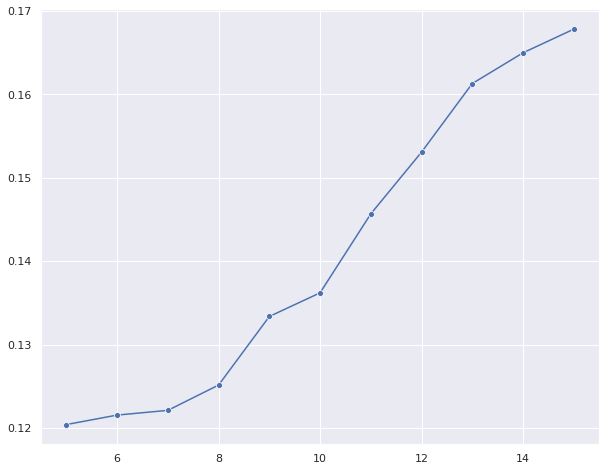

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(x = range(5,16), y = results[:11], marker='o')

In [ ]:
nums = range(5,21)
results = []
for i in nums:
  a = evalPrereq(i, earlierWpRes)
  results.append(a)
  print(a)
results

0.03767006802721088
0.038236961451247165
0.03993764172335601
0.03993764172335601
0.042205215419501126
0.04486961451247166
0.04486961451247166
0.045436507936507935
0.045436507936507935
0.045436507936507935
0.04628684807256236
0.04628684807256236
0.04628684807256236
0.04628684807256236
0.04628684807256236
0.04968820861678004


[0.03767006802721088,
 0.038236961451247165,
 0.03993764172335601,
 0.03993764172335601,
 0.042205215419501126,
 0.04486961451247166,
 0.04486961451247166,
 0.045436507936507935,
 0.045436507936507935,
 0.045436507936507935,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04968820861678004]

In [ ]:
results = [0.03767006802721088,
 0.038236961451247165,
 0.03993764172335601,
 0.03993764172335601,
 0.042205215419501126,
 0.04486961451247166,
 0.04486961451247166,
 0.045436507936507935,
 0.045436507936507935,
 0.045436507936507935,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04968820861678004]
len(results)

16

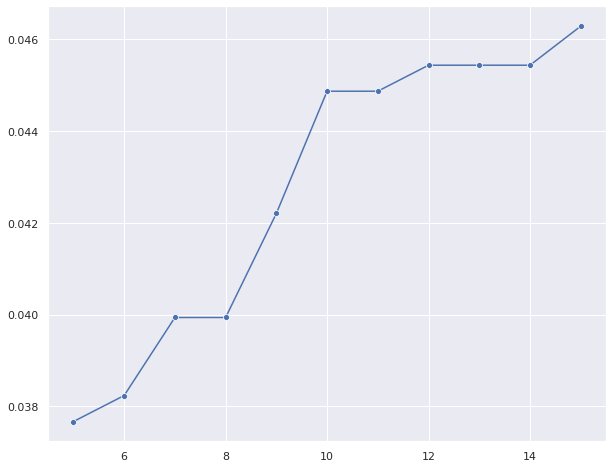

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(x = range(5,16), y = results[:11], marker='o')

т.к. не везде заполнены темы

In [ ]:
wp_outcomes[wp_outcomes.workprogram_id.isin(wp_disc_s.work_program_id.unique())].workprogram_id.unique().shape

(392,)

In [ ]:
short_outcomes = wp_outcomes[wp_outcomes.workprogram_id.isin(wp_disc_s.work_program_id.unique())]

In [ ]:
def evalResUSE(to_return = 10):
  all = short_outcomes.workprogram_id.unique()
  all_hits = np.array([])

  for i in all:
    orig_data = short_outcomes[short_outcomes.workprogram_id==i].item_id
    our_pred = itemDiscSim(i,vecFuncUSE,items_vecs, to_return=to_return).id

    res = set(orig_data).intersection(set(our_pred))
    all_hits = np.append(all_hits, np.array(len(res)/orig_data.shape[0]))

  return all_hits.mean()
  

In [ ]:
nums = range(5,11)
results = []
for i in nums:
  a = evalResUSE(i)
  results.append(a)
  print(a)
results

0.16693985085455804
0.18447026775969771
0.19013128757888073
0.21174506566587312
0.21841554229808446
0.22796277298689677


[0.16693985085455804,
 0.18447026775969771,
 0.19013128757888073,
 0.21174506566587312,
 0.21841554229808446,
 0.22796277298689677]

In [ ]:
nums = range(11,16)
results = []
for i in nums:
  a = evalResUSE(i)
  results.append(a)
  print(a)
results

0.23235300435416895
0.23689508217430802
0.24545314825788428
0.24989212623002552
0.25497410490894296


[0.23235300435416895,
 0.23689508217430802,
 0.24545314825788428,
 0.24989212623002552,
 0.25497410490894296]

In [ ]:
results = [0.16693985085455804,
 0.18447026775969771,
 0.19013128757888073,
 0.21174506566587312,
 0.21841554229808446,
 0.22796277298689677,0.23235300435416895,
 0.23689508217430802,
 0.24545314825788428,
 0.24989212623002552,
 0.25497410490894296]
len(results)

11

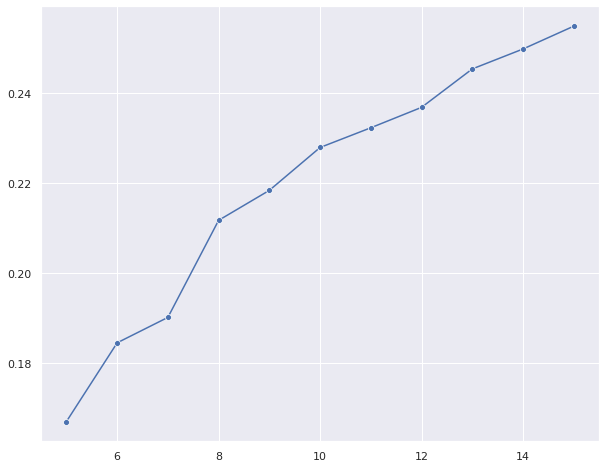

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(x = range(5,16), y = results[:11], marker='o')

In [ ]:
def vecFuncUSE(headers):
  return embed(headers)

In [ ]:
wp_topic_prepro.iloc[3535,-1]='not to do'

In [ ]:
wp_topic_prepro.iloc[3535]

Unnamed: 0                    3535
id                            4449
number                           5
description              Not to do
discipline_section_id         1544
url_online_course_id           NaN
prepro                   not to do
Name: 3535, dtype: object

In [ ]:
def evalRes1(to_return = 10):
  all = short_outcomes.workprogram_id.unique()
  all_hits = np.array([])

  for i in all:
    if i != 13299:
      orig_data = short_outcomes[short_outcomes.workprogram_id==i].item_id
     
      our_pred = itemDiscMatches(discipline_id = i, to_return=to_return).id

      res = set(orig_data).intersection(set(our_pred))
      all_hits = np.append(all_hits, np.array(len(res)/orig_data.shape[0]))

  return all_hits.mean()


In [ ]:
nums = range(5,16)
results = []
for i in nums:
  a = evalRes1(i)
  results.append(a)
  print(a)
results

0.07908526879671102
0.09144118156822484
0.10217175179367996
0.10994057078372658
0.1244617877026417
0.13324485956116114
0.14778526729210595
0.160698543984155
0.17047831256799345
0.18082623990413382
0.19312330629327182


[0.07908526879671102,
 0.09144118156822484,
 0.10217175179367996,
 0.10994057078372658,
 0.1244617877026417,
 0.13324485956116114,
 0.14778526729210595,
 0.160698543984155,
 0.17047831256799345,
 0.18082623990413382,
 0.19312330629327182]

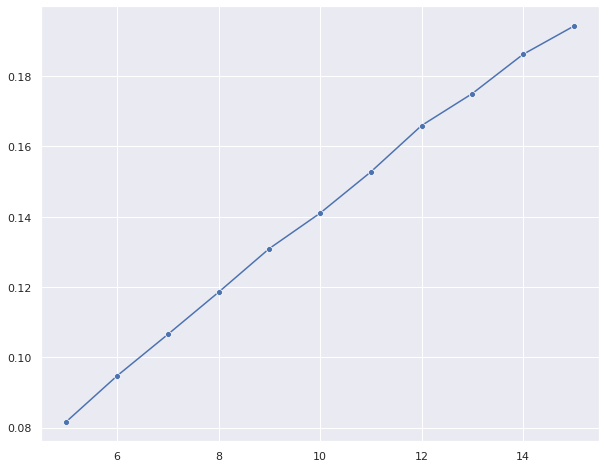

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(x = nums, y = results, marker='o')

In [ ]:
def vecFuncSBert(headers):
  return model_sbert.encode(headers, convert_to_tensor=True)


In [ ]:
item_vecs_sb = model_sbert.encode(dp_items['name'].values, convert_to_tensor=True)

In [ ]:
def evalResSB(to_return = 10):
  all = short_outcomes.workprogram_id.unique()
  hits = 0

  for i in all:
    orig_data = short_outcomes[short_outcomes.workprogram_id==i].item_id
    our_pred = itemDiscSim(i,vecFuncSBert,item_vecs_sb, to_return=to_return).id

    if set(orig_data).intersection(set(our_pred)):
      hits += 1

  return hits/all.shape[0]

In [ ]:
wp_prereq.workprogram_id.unique()

array([ 2811,  6986,    67,     5, 12186,  6990,  6991,  6992,  4861,
        3858,  4931,  4171,  2728,  2865,  6994,  2986,  6995,  3148,
        2777,  3410, 12799,  5982,  4911, 14522,  2639,  5983,  6993,
        3388,  6997, 12838,  6449,  3842,  7050, 11289, 11290,  3433,
        4714, 12525,  4713, 13707,  7898,  8156,  6194, 10907, 12801,
        6441, 12811, 12891,  7464, 12812,  6442,  6443,  6626, 13966,
        6634, 13972, 12270,  7496,  3205,  2746, 12813, 13977, 12894,
        2747,  4173,  3063,  6149,  5020, 12814,  5027,  3197, 12524,
       12436,  7273,  3840, 14525, 11272, 11554,  3115,  5146, 11273,
       11275, 11276,  5224, 11277, 11278, 11279, 12805,  4947,  4707,
        4706, 14527,  2641, 14528, 14026, 14027, 14031, 11472, 13300,
       13352,  3351, 14041,  3352, 12440,  3118, 14054, 12933, 12533,
       14064, 13832, 13372,  6635,  3465, 12534, 11394,  6632,  6633,
        6643,  6644,  6645, 13375,  4888, 13701,  3831, 13638, 12515,
       13127,  3442,

In [ ]:
dp_items[dp_items.id.isin(wp_prereq[wp_prereq.workprogram_id == 12186].item_id)]

,id,name,value,source,author_id,domain_id
7778,8364,Распоряжение правами на интеллектуальную собст...,19,uploaded,1.0,27.0
7781,8355,Охрана интеллектуальной собственности авторски...,22,uploaded,1.0,27.0
17920,8354,Правовые основы интеллектуальной собственности,20,uploaded,1.0,27.0


In [ ]:
dp_items[dp_items.id.isin(wp_outcomes[wp_outcomes.workprogram_id == 12223].item_id)]

,id,name,value,source,author_id,domain_id
17814,18491,Разработка игрового нарратива,1,NaN,NaN,62.0
17815,18493,Разработка персонажа игры,1,NaN,NaN,62.0
17816,18495,Использования игровых механик как средств выра...,1,NaN,NaN,62.0
17817,18492,Структурный подход к нарративу,1,NaN,NaN,62.0
17818,18496,Конструирование опыта игрока через взаимодейст...,1,NaN,NaN,62.0
17819,18494,Создание интерактивных элементов игрового пове...,1,NaN,NaN,62.0


# Оценка рез-в работы. Два графика в одном

In [ ]:
resultsbest = [0.16693985085455804,
 0.18447026775969771,
 0.19013128757888073,
 0.21174506566587312,
 0.21841554229808446,
 0.22796277298689677,0.23235300435416895,
 0.23689508217430802,
 0.24545314825788428,
 0.24989212623002552,
 0.25497410490894296]
resultsbase = [0.07908526879671102,
 0.09144118156822484,
 0.10217175179367996,
 0.10994057078372658,
 0.1244617877026417,
 0.13324485956116114,
 0.14778526729210595,
 0.160698543984155,
 0.17047831256799345,
 0.18082623990413382,
 0.19312330629327182]

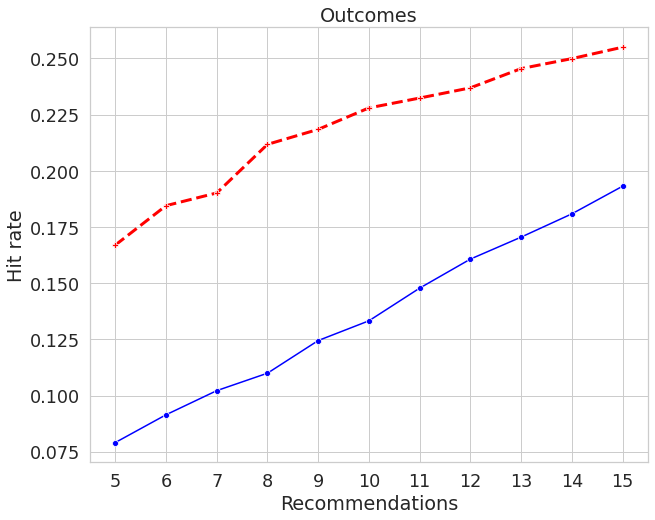

In [ ]:


sns.set(rc={'figure.figsize':(10,8)})

sns.set(font_scale=1.6)

sns.set_style("whitegrid")
#sns.set(style="whitegrid", rc={"lines.linewidth": 3})
ax = sns.lineplot(x = range(5,16), y = resultsbase[:11], marker='o', color='blue')
ax.set(xticks=range(5,16))

ax.set_title('Outcomes')

ax.set(xlabel='Recommendations', ylabel='Hit rate')
sns.set(rc={"lines.linewidth": 3})
sns.lineplot(x = range(5,16), y = resultsbest[:11], marker='P', color='red', linestyle="--")


In [ ]:
resultsbest = [0.12041086275780154,0.12154464960587408,0.12211154302991035,
  0.12514847208724758,0.13336842673577365,0.13620289385595508,
  0.14567001403736096,0.15307202245977755,0.16129197710830365,
  0.16497678436453944,0.16781125148472087,0.1703055825504805,
  0.1759745167908433,0.18099557283230752]

In [ ]:
resultsbase = [0.03767006802721088,
 0.038236961451247165,
 0.03993764172335601,
 0.03993764172335601,
 0.042205215419501126,
 0.04486961451247166,
 0.04486961451247166,
 0.045436507936507935,
 0.045436507936507935,
 0.045436507936507935,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236,
 0.04628684807256236]

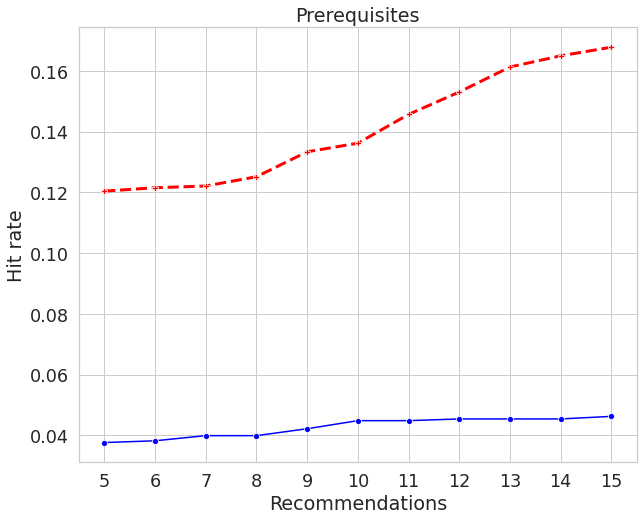

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

ax = sns.lineplot(x = range(5,16), y = resultsbase[:11], marker='o', color='blue')
ax.set(xlabel='Recommendations', ylabel='Hit rate')
ax.set_title('Prerequisites')
ax.set(xticks=range(5,16))
sns.set(rc={"lines.linewidth": 3})
sns.lineplot(x = range(5,16), y = resultsbest[:11], marker='P', color='red', linestyle="--")